라이브러리

In [1]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, concatenate, Input
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
tank = 1
model_name = 'rereredoRegressor_tank1dofood5'

In [2]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [3]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")


In [4]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [5]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[japonica_validation_sensor_val_tb['tank_id']==tank]

#시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 시계열 데이터의 개수 확인
training_counts = japonica_training_sensor_val_tb.groupby(japonica_training_sensor_val_tb['mea_dt'].dt.date).size()
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = training_counts[training_counts != 1440].index
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[~japonica_training_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


In [6]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_training_features.set_index('mea_dt', inplace=True)
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_features.sort_index()
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 00:00':'2021-09-10 23:59']
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

In [7]:
japonica_training_features_X = japonica_training_data[['do_mg','feed_quantity']]

japonica_validation_features_X = japonica_validation_data[['do_mg', 'feed_quantity']]

In [8]:
japonica_training_features_y = japonica_training_features_X[['do_mg']]

japonica_validation_features_y = japonica_validation_features_X[['do_mg']]

In [9]:
japonica_training_features_X_chunks = []
japonica_training_features_y_chunks = []

for i in range(0, len(japonica_training_features_X) - 179):
    japonica_training_features_X_chunks.append(np.array(japonica_training_features_X.iloc[i:i+180].values, dtype=np.float64))
japonica_training_features_X_chunks = np.array(japonica_training_features_X_chunks, dtype=np.float64)

for i in range(0, len(japonica_training_features_y) - 179):
    japonica_training_features_y_chunks.append(np.array(japonica_training_features_y.iloc[i:i+180].values, dtype=np.float64))
japonica_training_features_y_chunks = np.array(japonica_training_features_y_chunks, dtype=np.float64)

In [10]:
japonica_validation_features_X_chunks = []
japonica_validation_features_y_chunks = []


for i in range(0, len(japonica_validation_features_X) - 179):
    japonica_validation_features_X_chunks.append(np.array(japonica_validation_features_X.iloc[i:i+180].values, dtype=np.float64))
japonica_validation_features_X_chunks = np.array(japonica_validation_features_X_chunks, dtype=np.float64)

for i in range(0, len(japonica_validation_features_y) - 179):
    japonica_validation_features_y_chunks.append(np.array(japonica_validation_features_y.iloc[i:i+180].values, dtype=np.float64))
japonica_validation_features_y_chunks = np.array(japonica_validation_features_y_chunks, dtype=np.float64)

japonica_validation_features_X_chunks = []
japonica_validation_features_y_chunks = []


for i in range(0, len(japonica_validation_features_X) - 179):
    japonica_validation_features_X_chunks.append(np.array(japonica_validation_features_X.iloc[i:i+180].values, dtype=np.float64))
japonica_validation_features_X_chunks = np.array(japonica_validation_features_X_chunks, dtype=np.float64)

for i in range(0, len(japonica_validation_features_y) - 179):
    japonica_validation_features_y_chunks.append(np.array(japonica_validation_features_y.iloc[i:i+180].values, dtype=np.float64))
japonica_validation_features_y_chunks = np.array(japonica_validation_features_y_chunks, dtype=np.float64)

In [11]:
# shape확인
nCar = japonica_training_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64621 nVar: 2
nCar: 64621 nVar: 180
nCar: 64621 nVar: 2
nCar: 64621 nVar: 180


In [12]:
japonica_training_features_X_chunks_crop = japonica_training_features_X_chunks[:-180]
japonica_training_features_y_chunks_crop = japonica_training_features_y_chunks[180:]

japonica_validation_features_X_chunks_crop = japonica_validation_features_X_chunks[:-180]
japonica_validation_features_y_chunks_crop = japonica_validation_features_y_chunks[180:]

In [13]:
nCar = japonica_training_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64441 nVar: 2
nCar: 64441 nVar: 180
nCar: 64441 nVar: 2
nCar: 64441 nVar: 180


In [14]:
japonica_training_features_X_chunks_crop_a = japonica_training_features_X_chunks_crop[:, :, 0].reshape((-1, 180, 1))
japonica_training_features_X_chunks_crop_b = japonica_training_features_X_chunks_crop[:, :, 1].reshape((-1, 180, 1))

japonica_validation_features_X_chunks_crop_a = japonica_validation_features_X_chunks_crop[:, :, 0].reshape((-1, 180, 1))
japonica_validation_features_X_chunks_crop_b = japonica_validation_features_X_chunks_crop[:, :, 1].reshape((-1, 180, 1))

In [15]:
nCar = japonica_training_features_X_chunks_crop_a.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks_crop_a.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_X_chunks_crop_b.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks_crop_b.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks_crop_a.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks_crop_a.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks_crop_b.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks_crop_b.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64441 nVar: 1
nCar: 64441 nVar: 180
nCar: 64441 nVar: 1
nCar: 64441 nVar: 180


LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [16]:
# 첫 번째 입력: A 피처
input_a = Input(shape=(180, 1))
lstm_a = LSTM(128)(input_a)

# 두 번째 입력: B 피처
input_b = Input(shape=(180, 1))
lstm_b = LSTM(128)(input_b)

# A와 B의 출력을 결합
concatenated = concatenate([lstm_a, lstm_b])

# 출력층 추가
output = Dense(180, activation='linear')(concatenated)

# Multi-Input 모델 구성
model = Model(inputs=[input_a, input_b], outputs=output)
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])


checkpoint = ModelCheckpoint(model_name + '_best.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.


hist = model.fit([japonica_training_features_X_chunks_crop_a, japonica_training_features_X_chunks_crop_b], japonica_training_features_y_chunks_crop, epochs = 200, batch_size = 32, validation_data=([japonica_validation_features_X_chunks_crop_a, japonica_validation_features_X_chunks_crop_b], japonica_validation_features_y_chunks_crop), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name+'.h5')

2023-07-11 13:36:37.312390: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 13:36:37.985184: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7951 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:d5:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 1)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 180, 1)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 128)          66560       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 128)          66560       input_2[0][0]                    
______________________________________________________________________________________________

2023-07-11 13:36:39.024527: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2023-07-11 13:36:42.847561: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200
2023-07-11 13:36:43.882156: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2014/2014 [==============================] - 90s 42ms/step - loss: 1.3415 - mae: 0.6354 - r_squared: -0.0460 - val_loss: 0.3539 - val_mae: 0.3818 - val_r_squared: -2.3466
Epoch 2/200
2014/2014 [==============================] - 83s 41ms/step - loss: 0.3587 - mae: 0.3858 - r_squared: 0.7388 - val_loss: 0.3462 - val_mae: 0.3714 - val_r_squared: -2.0348
Epoch 3/200
2014/2014 [==============================] - 81s 40ms/step - loss: 0.3478 - mae: 0.3792 - r_squared: 0.7472 - val_loss: 0.3312 - val_mae: 0.3649 - val_r_squared: -2.1798
Epoch 4/200
2014/2014 [==============================] - 83s 41ms/step - loss: 0.3450 - mae: 0.3790 - r_squared: 0.7493 - val_loss: 0.3389 - val_mae: 0.3804 - val_r_squared: -2.5434
Epoch 5/200
2014/2014 [==============================] - 82s 41ms/step - loss: 0.3354 - mae: 0.3721 - r_squared: 0.7555 - val_loss: 0.3464 - val_mae: 0.3947 - val_r_squared: -2.8804
Epoch 6/200
2014/2014 [==============================] - 79s 39ms/step - loss: 0.3291 - mae: 0.3684 -

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2014/2014 [==============================] - 77s 38ms/step - loss: 0.3202 - mae: 0.3540 - r_squared: 0.7668 - val_loss: 0.3207 - val_mae: 0.3580 - val_r_squared: -2.1504
Epoch 00015: early stopping


모델 평가

In [17]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(model_name)
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [18]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

In [19]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(2), weights[:, 0])
ax.set_xticks(range(2))
ax.set_xticklabels(['do_mg', 'feed_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

IndexError: list index out of range

In [20]:
japonica_validation_features_X

,do_mg,feed_quantity
mea_dt,,
2021-07-21 00:00:00,7.7,0.0
2021-07-21 00:01:00,7.8,0.0
2021-07-21 00:02:00,7.8,0.0
2021-07-21 00:03:00,7.8,0.0
2021-07-21 00:04:00,7.9,0.0
...,...,...
2021-09-08 23:55:00,8.7,0.0
2021-09-08 23:56:00,8.7,0.0
2021-09-08 23:57:00,8.7,0.0


In [21]:
X_test = japonica_validation_features_X.loc['2021-07-22 00:00':'2021-09-08 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 2))

X_test_reshape_a = X_test_reshape[:, :, 0].reshape((-1, 180, 1))
X_test_reshape_b = X_test_reshape[:, :, 1].reshape((-1, 180, 1))

# shape확인
nCar = X_test_reshape_a.shape[0] # 데이터 개수
nVar = X_test_reshape_b.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape_a.shape[0] # 데이터 개수
nVar = X_test_reshape_b.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 351 nVar: 1
nCar: 351 nVar: 1


In [22]:
y_date = japonica_validation_features_X.loc['2021-07-22 03:00':'2021-09-08 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 63180 nVar: 1
nCar: 351 nVar: 180


63180


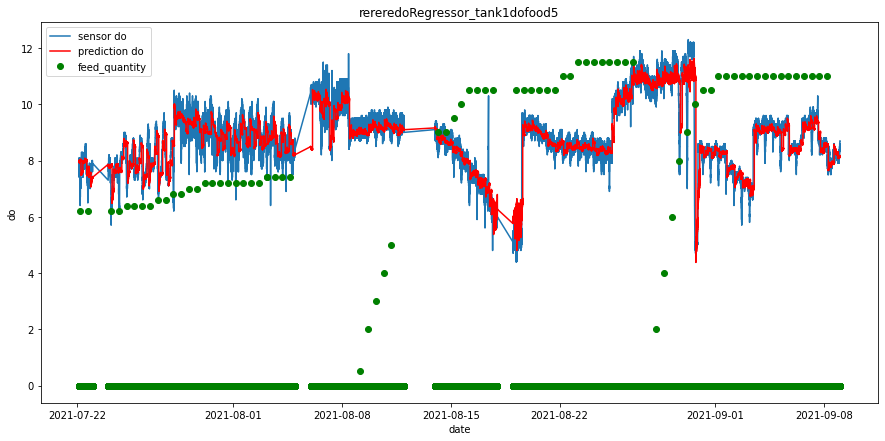

11/11 [==============================] - 1s 14ms/step - loss: 0.3641 - mae: 0.3703 - r_squared: 0.4679
MSE // MAE // R-squared  [0.364148885011673, 0.3702576160430908, 0.4679016172885895]


In [23]:
grapeNEva(model,[X_test_reshape_a, X_test_reshape_b], y_test, y_date[['feed_quantity']], y_test_reshape)

In [24]:
X_test = japonica_validation_features_X.loc['2021-07-22 00:00':'2021-07-31 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 2))

X_test_reshape_a = X_test_reshape[:, :, 0].reshape((-1, 180, 1))
X_test_reshape_b = X_test_reshape[:, :, 1].reshape((-1, 180, 1))

# shape확인
nCar = X_test_reshape_a.shape[0] # 데이터 개수
nVar = X_test_reshape_b.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape_a.shape[0] # 데이터 개수
nVar = X_test_reshape_b.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 71 nVar: 1
nCar: 71 nVar: 1


In [25]:
y_date = japonica_validation_features_X.loc['2021-07-22 03:00':'2021-07-31 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 12780 nVar: 1
nCar: 71 nVar: 180


12780


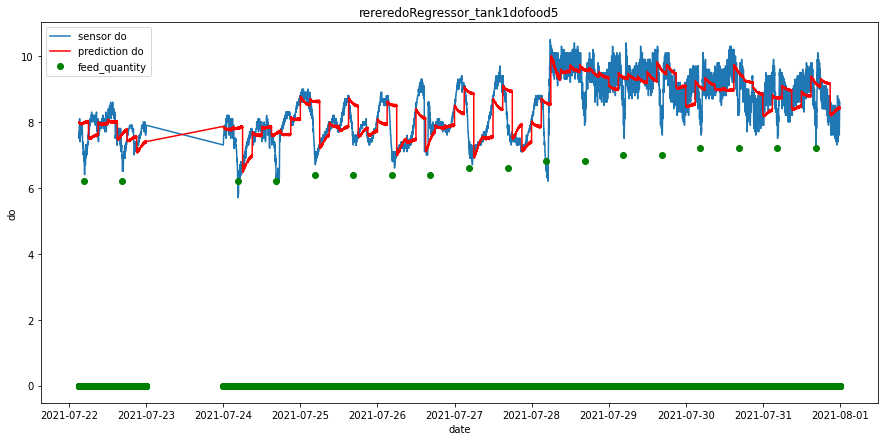

3/3 [==============================] - 0s 14ms/step - loss: 0.3732 - mae: 0.4563 - r_squared: 0.1200
MSE // MAE // R-squared  [0.3731500506401062, 0.4563008248806, 0.11997135728597641]


In [26]:
grapeNEva(model,[X_test_reshape_a, X_test_reshape_b], y_test, y_date[['feed_quantity']], y_test_reshape)

In [27]:
X_test = japonica_validation_features_X.loc['2021-07-22 00:00':'2021-07-22 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 2))

X_test_reshape_a = X_test_reshape[:, :, 0].reshape((-1, 180, 1))
X_test_reshape_b = X_test_reshape[:, :, 1].reshape((-1, 180, 1))

# shape확인
nCar = X_test_reshape_a.shape[0] # 데이터 개수
nVar = X_test_reshape_b.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape_a.shape[0] # 데이터 개수
nVar = X_test_reshape_b.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 7 nVar: 1
nCar: 7 nVar: 1


In [28]:
y_date = japonica_validation_features_X.loc['2021-07-22 03:00':'2021-07-22 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1260 nVar: 1
nCar: 7 nVar: 180


1260


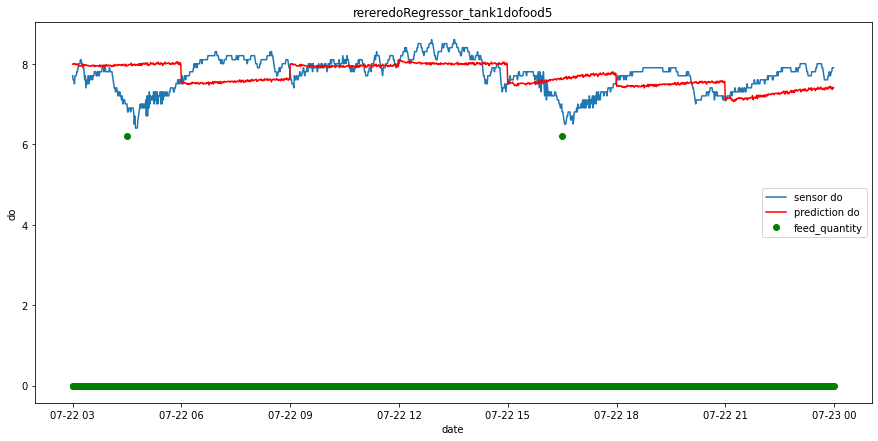

1/1 [==============================] - 0s 48ms/step - loss: 0.2211 - mae: 0.3887 - r_squared: -0.2350
MSE // MAE // R-squared  [0.22110965847969055, 0.3886740505695343, -0.23496174812316895]


In [29]:
grapeNEva(model,[X_test_reshape_a, X_test_reshape_b], y_test, y_date[['feed_quantity']], y_test_reshape)

In [30]:
X_test = japonica_validation_features_X.loc['2021-07-22 00:00':'2021-07-22 11:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 2))

X_test_reshape_a = X_test_reshape[:, :, 0].reshape((-1, 180, 1))
X_test_reshape_b = X_test_reshape[:, :, 1].reshape((-1, 180, 1))

# shape확인
nCar = X_test_reshape_a.shape[0] # 데이터 개수
nVar = X_test_reshape_b.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape_a.shape[0] # 데이터 개수
nVar = X_test_reshape_b.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 4 nVar: 1
nCar: 4 nVar: 1


In [31]:
y_date = japonica_validation_features_X.loc['2021-07-22 03:00':'2021-07-22 14:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1
nCar: 4 nVar: 180


720


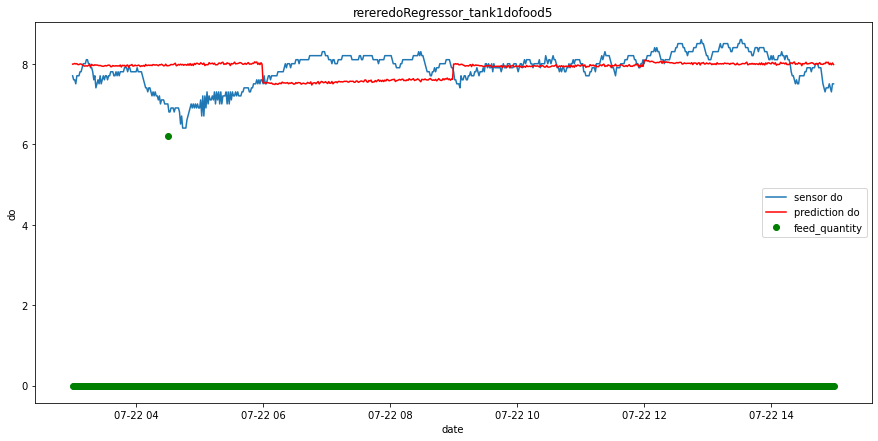

1/1 [==============================] - 0s 57ms/step - loss: 0.2370 - mae: 0.3844 - r_squared: -0.3946
MSE // MAE // R-squared  [0.2370014637708664, 0.3844246566295624, -0.3945978879928589]


In [32]:
grapeNEva(model,[X_test_reshape_a, X_test_reshape_b], y_test, y_date[['feed_quantity']], y_test_reshape)

In [33]:
japonica_validation_features_X.at['2021-07-22 08:00', 'feed_quantity'] = 6

X_test = japonica_validation_features_X.loc['2021-07-22 00:00':'2021-07-22 11:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 2))

X_test_reshape_a = X_test_reshape[:, :, 0].reshape((-1, 180, 1))
X_test_reshape_b = X_test_reshape[:, :, 1].reshape((-1, 180, 1))

# shape확인
nCar = X_test_reshape_a.shape[0] # 데이터 개수
nVar = X_test_reshape_b.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape_a.shape[0] # 데이터 개수
nVar = X_test_reshape_b.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 4 nVar: 1
nCar: 4 nVar: 1


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [34]:
y_date = japonica_validation_features_X.loc['2021-07-22 03:00':'2021-07-22 14:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1
nCar: 4 nVar: 180


720


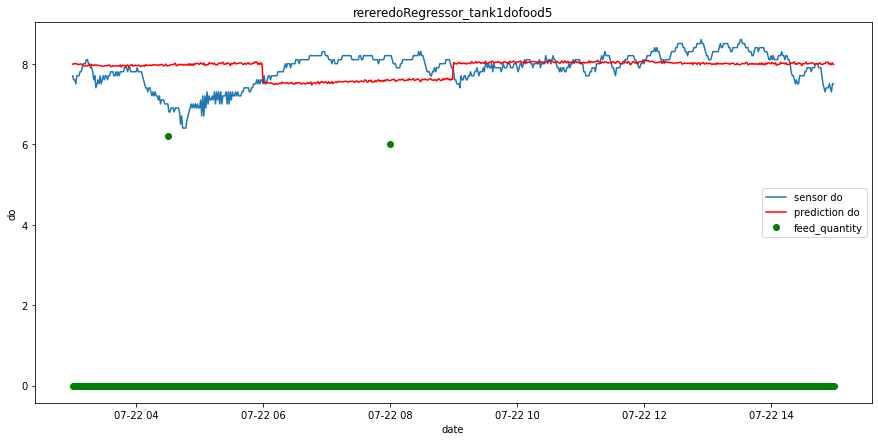

1/1 [==============================] - 0s 49ms/step - loss: 0.2385 - mae: 0.3879 - r_squared: -0.4036
MSE // MAE // R-squared  [0.23852992057800293, 0.38792508840560913, -0.4035918712615967]


In [35]:
grapeNEva(model,[X_test_reshape_a, X_test_reshape_b], y_test, y_date[['feed_quantity']], y_test_reshape)